TRABALHO FINAL LÓGICA FUZZY - PARTE 2: EXTRAÇÃO DE REGRAS

Nome: MAYTA SOARES CUSTODIO\
Matrícula: 192.671.147\
Turma: 2019.2

Estudo de caso: A seguinte série temporal é referente a ações diárias da
"Empresa X" na Bolsa de São Paulo. Os valores foram escalados para fins
práticos. Pode-se criar um modelo fuzzy para previsão um passo a frente ( 1 dia )
usando o aplicativo Fuzzy Rules. Obtenha o modelo com o menor erro de teste,
modificando o número de conjuntos, tamanho da janela, operações de
interseção, implicação e defuzzyficação. 

Todos os códigos serão comentados, passo a passo

In [1]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=3d28bbc619cf157d3b53c2acd121fec18c463292221ea89897a7185fd39380ee
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [2]:
# Importamos as bibliotecas necessárias

import tensorflow as tf
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from fuzzy_rules import extract_rules,config_input_variable,config_output_variable
from sklearn.metrics import mean_squared_error

In [45]:
# Abrimos o arquivo 'EmpresaX' e definimos o tamanho da janela e dos conjuntos para iniciar o primeiro teste
# depois aplicaremos outras medidas

file_path='EmpresaX.txt'
windows_size=5
nb_sets = 5


In [46]:
# Realizamos um tratamento na base, trocando as vírgulas por pontos

def preprocessing(line):
  line = line.strip().replace(',','.')
  return float(line)

with open(file_path,'r') as file:
  series = [preprocessing(line) for line in file]

In [47]:
# Aplicamos a fórmula do tesorflow colocando a princípio o tamanho da janela em 3 e passo em 1 (um dia) e 
# retiramos os dados que sobrarem

dataset = tf.data.Dataset.from_tensor_slices(series)
dataset = dataset.window(windows_size + 1, shift=1, drop_remainder=True)
for window_dataset in dataset:
  for w in window_dataset:
    print(w.numpy(), end=' ')
  print('')

0.429 0.443 0.451 0.455 0.44 0.433 
0.443 0.451 0.455 0.44 0.433 0.423 
0.451 0.455 0.44 0.433 0.423 0.412 
0.455 0.44 0.433 0.423 0.412 0.411 
0.44 0.433 0.423 0.412 0.411 0.426 
0.433 0.423 0.412 0.411 0.426 0.436 
0.423 0.412 0.411 0.426 0.436 0.441 
0.412 0.411 0.426 0.436 0.441 0.446 
0.411 0.426 0.436 0.441 0.446 0.443 
0.426 0.436 0.441 0.446 0.443 0.437 
0.436 0.441 0.446 0.443 0.437 0.426 
0.441 0.446 0.443 0.437 0.426 0.427 
0.446 0.443 0.437 0.426 0.427 0.431 
0.443 0.437 0.426 0.427 0.431 0.436 
0.437 0.426 0.427 0.431 0.436 0.432 
0.426 0.427 0.431 0.436 0.432 0.433 
0.427 0.431 0.436 0.432 0.433 0.424 
0.431 0.436 0.432 0.433 0.424 0.42 
0.436 0.432 0.433 0.424 0.42 0.416 
0.432 0.433 0.424 0.42 0.416 0.405 
0.433 0.424 0.42 0.416 0.405 0.408 
0.424 0.42 0.416 0.405 0.408 0.414 
0.42 0.416 0.405 0.408 0.414 0.417 
0.416 0.405 0.408 0.414 0.417 0.4 
0.405 0.408 0.414 0.417 0.4 0.404 
0.408 0.414 0.417 0.4 0.404 0.396 
0.414 0.417 0.4 0.404 0.396 0.393 
0.417 0.4 0.404 0.39

In [49]:
# Verificamos as informação do database de valores de min/max, shape, tamanho da janela

data = np.stack([list(window_dataset) for window_dataset in dataset], axis=0)
print('data.shape: {}'.format(data.shape))
min_value = data.min()
max_value = data.max()

print('File Path: {}\nWindows Siz: {}\nMin Value: {:.2f}\nMax Value: {:.2f}'.\
      format(file_path, windows_size, min_value, max_value))

data.shape: (173, 6)
File Path: EmpresaX.txt
Windows Siz: 5
Min Value: 0.36
Max Value: 0.46


In [50]:
# Realizamos a configuração para utilizarmos a biblioteca de fuzzy rules

var_config = {
'windows_size':windows_size,
'nb_sets':nb_sets,
'min':min_value-0.01,
'max':max_value+0.01,
'type':'input & output'
}

In [51]:
# Criação das variáveis de entrada, saída e a junção delas

input_variables  = [config_input_variable('i_{}'.format(i+1), var_config['nb_sets'], var_config['min'], var_config['max']) for i in range(var_config['windows_size'])]
output_variables = [config_output_variable('output', var_config['nb_sets'], var_config['min'], var_config['max'])]
variables = input_variables + output_variables

In [52]:
# Função de extração de regras, construção de sistema a partir das regras e simulador do sistema

rules = extract_rules(variables, data)
system = ctrl.ControlSystem(rules)
sim = ctrl.ControlSystemSimulation(system)

In [53]:
# Realizamos uma simulação para verificar como o sistema se comporta

output_real = []
output_prev = []
for instance in data:
  for i,v in enumerate(instance[:-1]):
    sim.input['i_{}'.format(i+1)]=instance[i]
  sim.compute()
  output_prev.append(sim.output['output'])
  output_real.append(instance[-1])

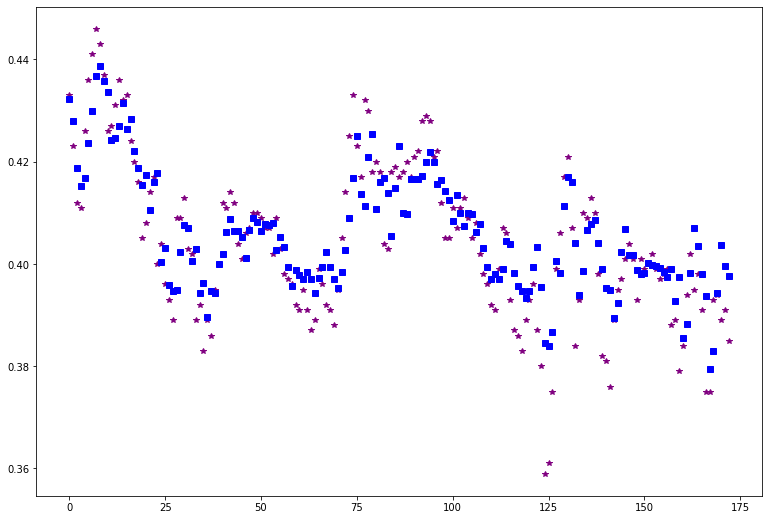

In [54]:
# Plotamos um gráfico com as variáveis

plt.figure(figsize=(13,9))
plt.plot(output_real,'*', color='purple', label='Real')
plt.plot(output_prev,'s', color='blue', label='Previsto')

In [56]:
# Nosso erro está ainda alto: 6.76e-05 = 6.76 x 10-5 = 0.0000676

mean_squared_error(output_real, output_prev)

6.76469571098739e-05

In [284]:
# Agora vamos realizar uma série de testes, modificando o numero da janela e conjuntos e todos os passos novamente
# Será ultizada a combinação que demonstrar o menor erro e ao final, uma lista com as tentativas

windows_size = 9
nb_sets = 12

In [285]:
def preprocessing(line):
  line = line.strip().replace(',','.')
  return float(line)

with open(file_path,'r') as file:
  series = [preprocessing(line) for line in file]

In [286]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset = dataset.window(windows_size + 1, shift=1, drop_remainder=True)
for window_dataset in dataset:
  for w in window_dataset:
    print(w.numpy(), end=' ')

0.429 0.443 0.451 0.455 0.44 0.433 0.423 0.412 0.411 0.426 0.443 0.451 0.455 0.44 0.433 0.423 0.412 0.411 0.426 0.436 0.451 0.455 0.44 0.433 0.423 0.412 0.411 0.426 0.436 0.441 0.455 0.44 0.433 0.423 0.412 0.411 0.426 0.436 0.441 0.446 0.44 0.433 0.423 0.412 0.411 0.426 0.436 0.441 0.446 0.443 0.433 0.423 0.412 0.411 0.426 0.436 0.441 0.446 0.443 0.437 0.423 0.412 0.411 0.426 0.436 0.441 0.446 0.443 0.437 0.426 0.412 0.411 0.426 0.436 0.441 0.446 0.443 0.437 0.426 0.427 0.411 0.426 0.436 0.441 0.446 0.443 0.437 0.426 0.427 0.431 0.426 0.436 0.441 0.446 0.443 0.437 0.426 0.427 0.431 0.436 0.436 0.441 0.446 0.443 0.437 0.426 0.427 0.431 0.436 0.432 0.441 0.446 0.443 0.437 0.426 0.427 0.431 0.436 0.432 0.433 0.446 0.443 0.437 0.426 0.427 0.431 0.436 0.432 0.433 0.424 0.443 0.437 0.426 0.427 0.431 0.436 0.432 0.433 0.424 0.42 0.437 0.426 0.427 0.431 0.436 0.432 0.433 0.424 0.42 0.416 0.426 0.427 0.431 0.436 0.432 0.433 0.424 0.42 0.416 0.405 0.427 0.431 0.436 0.432 0.433 0.424 0.42 0.416 0

In [287]:
data = np.stack([list(window_dataset) for window_dataset in dataset], axis=0)
print('data.shape: {}'.format(data.shape))
min_value = data.min()
max_value = data.max()

print('File Path: {}\nWindows Siz: {}\nMin Value: {:.2f}\nMax Value: {:.2f}'.\
      format(file_path, windows_size, min_value, max_value))

data.shape: (169, 10)
File Path: EmpresaX.txt
Windows Siz: 9
Min Value: 0.36
Max Value: 0.46


In [288]:
var_config = {
'windows_size':windows_size,
'nb_sets':nb_sets,
'min':min_value-0.01,
'max':max_value+0.01,
'type':'input & output'
}

In [289]:
input_variables  = [config_input_variable('i_{}'.format(i+1), var_config['nb_sets'], var_config['min'], var_config['max']) for i in range(var_config['windows_size'])]
output_variables = [config_output_variable('output', var_config['nb_sets'], var_config['min'], var_config['max'])]
variables = input_variables + output_variables

In [290]:
rules = extract_rules(variables, data)
system = ctrl.ControlSystem(rules)
sim = ctrl.ControlSystemSimulation(system)

In [291]:
output_real = []
output_prev = []
for instance in data:
  for i,v in enumerate(instance[:-1]):
    sim.input['i_{}'.format(i+1)]=instance[i]
  sim.compute()
  output_prev.append(sim.output['output'])
  output_real.append(instance[-1])

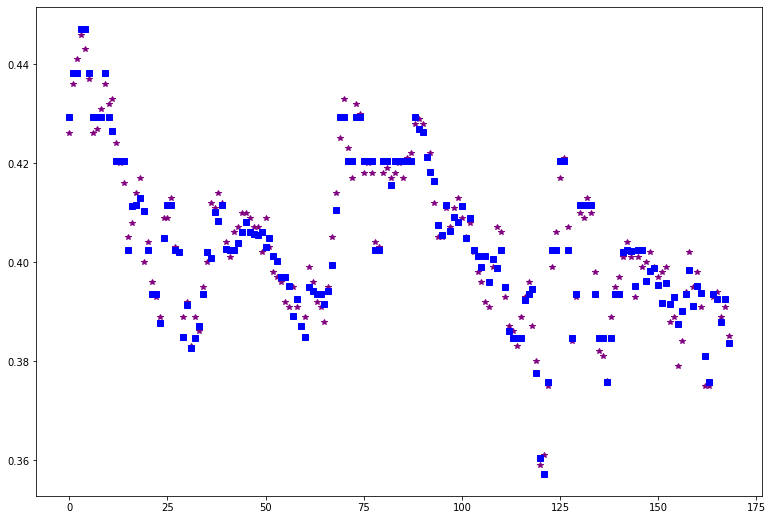

In [292]:
# Plotamos um novo gráfico com as variáveis

plt.figure(figsize=(13,9))
plt.plot(output_real,'*', color='purple', label='Real')
plt.plot(output_prev,'s', color='blue', label='Previsto')

In [293]:
# windows_size=5 , nb_sets = 5 -  Erro 6.76e-05 = 6.76 x 10-5 = 0.0000676
# windows_size=10 ,nb_sets = 12 - Erro 8.52e-05 = 8.52 x 10-5 = 0.0000852
# windows_size=6 , nb_sets = 9 -  Erro 3.07e-05 = 3.07 x 10-5 = 0.0000307
# windows_size=6 , nb_sets = 7 -  Erro 4.48e-05 = 4.48 x 10-5 = 0.0000448 
# windows_size=7 , nb_sets = 10 - Erro 2.01e-05 = 2.01 x 10-5 = 0.0000201
# windows_size=8 , nb_sets = 10 - Erro 1.90e-05 = 1.90 x 10-5 = 0.0000190
# windows_size=9 , nb_sets = 10 - Erro 1.66e-05 = 1.66 x 10-5 = 0.0000166
# windows_size=9 , nb_sets = 11 - Erro 1.57e-05 = 1.57 x 10-5 = 0.0000157
# windows_size=9 , nb_sets = 9 -  Erro 2.33e-05 = 2.33 x 10-5 = 0.0000233
# windows_size=9 , nb_sets = 8 -  Erro 2.67e-05 = 2.67 x 10-5 = 0.0000267
# windows_size=9 , nb_sets = 7 -  Erro 3.76e-05 = 3.76 x 10-5 = 0.0000376
# windows_size=8 , nb_sets = 9 -  Erro 2.66e-05 = 2.66 x 10-5 = 0.0000266
# windows_size=8 , nb_sets = 12 - Erro 1.40e-05 = 1.08 x 10-5 = 0.0000140


# Melhor resultado
# windows_size=9 , nb_sets = 12 - Erro 1.08e-05 = 1.08 x 10-5 = 0.0000108


mean_squared_error(output_real, output_prev)

1.0822539603223514e-05

Obrigada, Prof. Cristian! 